/tmp/ipykernel_6341/1385444744.py:18: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delimiter='|')  # Adjust delimiter based on the file format


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Data columns (total 52 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   UnderwrittenCoverID       1000098 non-null  int64  
 1   PolicyID                  1000098 non-null  int64  
 2   TransactionMonth          1000098 non-null  object 
 3   IsVATRegistered           1000098 non-null  bool   
 4   Citizenship               1000098 non-null  object 
 5   LegalType                 1000098 non-null  object 
 6   Title                     1000098 non-null  object 
 7   Language                  1000098 non-null  object 
 8   Bank                      854137 non-null   object 
 9   AccountType               959866 non-null   object 
 10  MaritalStatus             991839 non-null   object 
 11  Gender                    990562 non-null   object 
 12  Country                   1000098 non-null  object 
 13  Province                  1

/tmp/ipykernel_6341/1385444744.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].median(), inplace=True)
/tmp/ipykernel_6341/1385444744.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

Linear Regression - MAE: 5357.900799742089, MSE: 76496528.87850624, R2: 0.09855374823752228
Random Forest - MAE: 508.3977863042251, MSE: 4362148.338217033, R2: 0.32819829730522976
XGBoost - MAE: 4335.13037109375, MSE: 54744740.0, R2: 0.21501761674880981


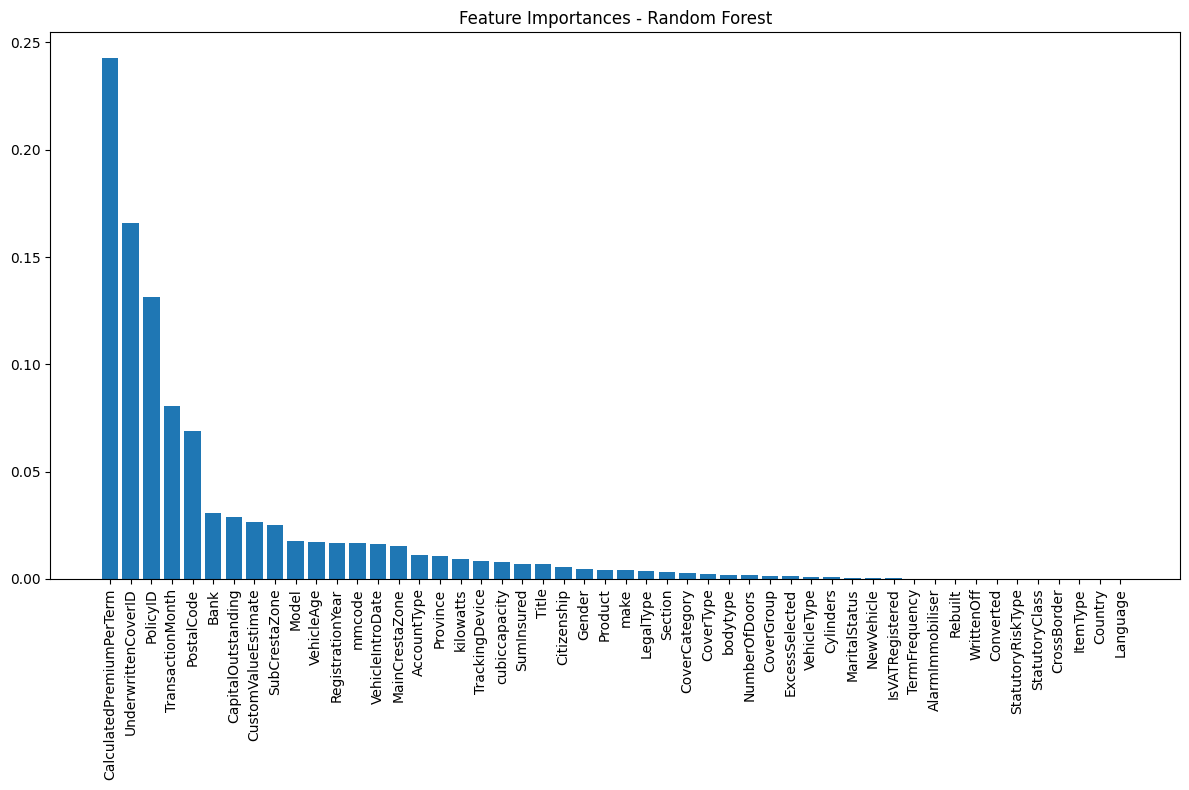

Random Forest Top Features:
CalculatedPremiumPerTerm: 0.2426
UnderwrittenCoverID: 0.1660
PolicyID: 0.1312
TransactionMonth: 0.0807
PostalCode: 0.0688
Bank: 0.0304
CapitalOutstanding: 0.0288
CustomValueEstimate: 0.0264
SubCrestaZone: 0.0251
Model: 0.0174


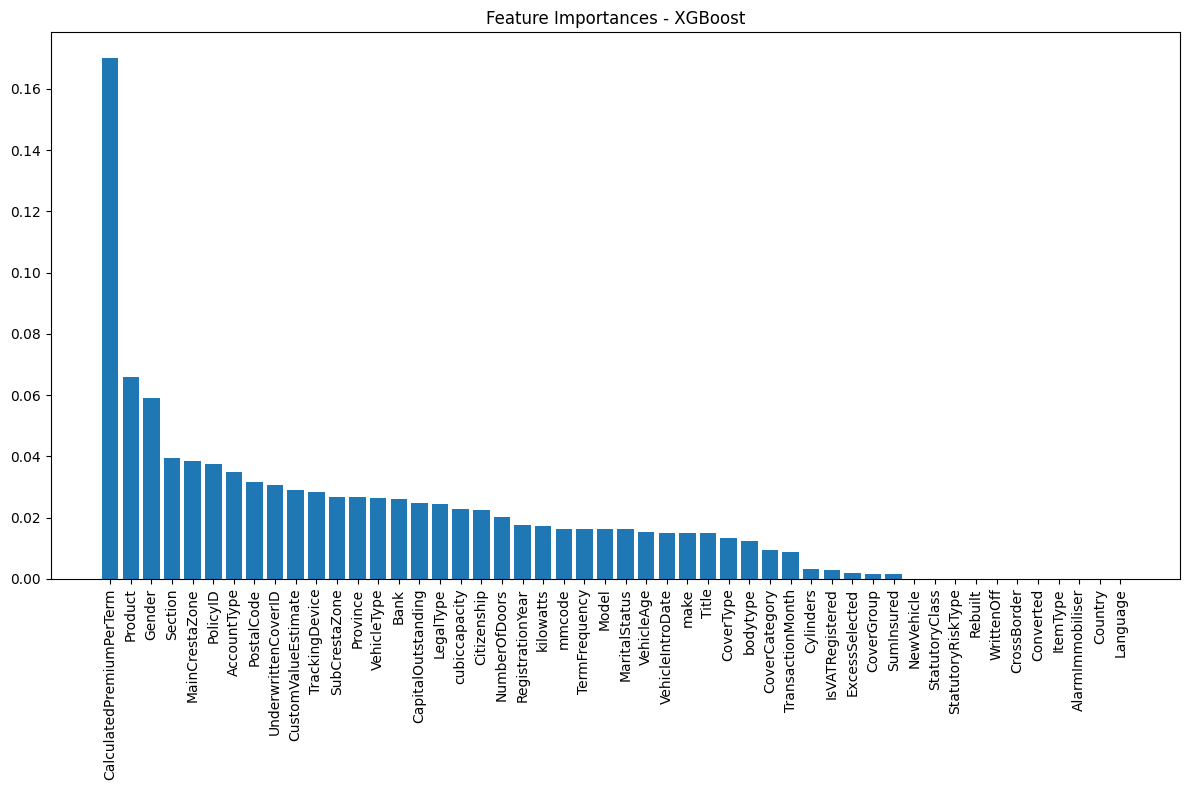

XGBoost Top Features:
CalculatedPremiumPerTerm: 0.1700
Product: 0.0658
Gender: 0.0589
Section: 0.0394
MainCrestaZone: 0.0385
PolicyID: 0.0376
AccountType: 0.0349
PostalCode: 0.0315
UnderwrittenCoverID: 0.0305
CustomValueEstimate: 0.0288


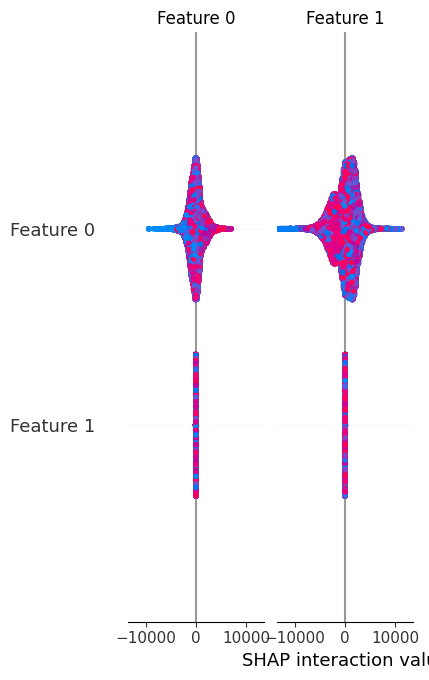

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap
import matplotlib.pyplot as plt

# ---------------------------
# Step 1: Load and Inspect Data
# ---------------------------

# Load the dataset
file_path = '../data/MachineLearningRating_v3.txt'
df = pd.read_csv(file_path, delimiter='|')  # Adjust delimiter based on the file format

# Inspect the dataset
print(df.info())
print(df.describe())
print(df.head())

# ---------------------------
# Step 2: Data Preparation
# ---------------------------

# Handle Missing Values
# Fill numeric columns with median values and categorical columns with mode
for column in df.columns:
    if df[column].dtype == 'object':
        df[column].fillna(df[column].mode()[0], inplace=True)
    else:
        df[column].fillna(df[column].median(), inplace=True)

# Drop any columns with too many missing values (more than 40%)
missing_percent = df.isnull().sum() / len(df) * 100
df = df.loc[:, missing_percent < 40]

# Feature Engineering
# Calculate vehicle age based on RegistrationYear
current_year = 2024
df['VehicleAge'] = current_year - df['RegistrationYear']

# Ensure all columns have uniform data types
for col in df.columns:
    if df[col].apply(lambda x: isinstance(x, (int, float, str))).any():
        df[col] = df[col].astype(str)

# Encode Categorical Variables
label_encoders = {}
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))  # Ensure uniform string type
    label_encoders[col] = le

# ---------------------------
# Step 3: Train-Test Split
# ---------------------------

# Define target and features
X = df.drop(['TotalPremium', 'TotalClaims'], axis=1)
y = df[['TotalPremium', 'TotalClaims']]

# Split data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize numeric features for better performance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ---------------------------
# Step 4: Model Building
# ---------------------------

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)

# ---------------------------
# Step 5: Model Evaluation
# ---------------------------

models = {'Linear Regression': lr_model, 'Random Forest': rf_model, 'XGBoost': xgb_model}
for name, model in models.items():
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f'{name} - MAE: {mae}, MSE: {mse}, R2: {r2}')

# ---------------------------
# Step 6: Feature Importance and Interpretability
# ---------------------------

# Random Forest Feature Importance
rf_importances = rf_model.feature_importances_
rf_indices = np.argsort(rf_importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature Importances - Random Forest")
plt.bar(range(X.shape[1]), rf_importances[rf_indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[rf_indices], rotation=90)
plt.tight_layout()
plt.show()

print("Random Forest Top Features:")
for i in rf_indices[:10]:
    print(f"{X.columns[i]}: {rf_importances[i]:.4f}")

# XGBoost Feature Importance
xgb_importances = xgb_model.feature_importances_
xgb_indices = np.argsort(xgb_importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature Importances - XGBoost")
plt.bar(range(X.shape[1]), xgb_importances[xgb_indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[xgb_indices], rotation=90)
plt.tight_layout()
plt.show()

print("XGBoost Top Features:")
for i in xgb_indices[:10]:
    print(f"{X.columns[i]}: {xgb_importances[i]:.4f}")

# SHAP Analysis for XGBoost
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test, check_additivity=False)

# Summary plot to interpret feature importance
shap.summary_plot(shap_values, X_test)

# ---------------------------
# Notes:
# ---------------------------
# 1. Feature importance visualizations for Random Forest and XGBoost.
# 2. SHAP summary plot highlights the impact of features.
# 3. Additional textual output lists top contributing features for insights.
